In [55]:
import os
import glob
import time
import numpy as np
import matplotlib.pyplot as plt
import cv2
import sys
from tqdm import tqdm

import torch
import torch.nn.functional as F
from torch import tensor
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

sys.path.append('../../../src')
from common import common, transform, json
from common.json import IA_FORMAT, START_IDX
from common.functions import gauss, cos_similarity
from common.default import PASSING_DEFAULT
from display.display import display
from individual_activity.individual_activity import IndividualActivity

import warnings
warnings.simplefilter("ignore")

In [2]:
device_idx = 0
device = f'cuda:{device_idx}' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

# Indivisual Activity をロード

In [3]:
data_settings = [
    {'room_num': '02', 'date': '20210903', 'option': 'passing'},
    {'room_num': '08', 'date': '20210915', 'option': 'passing'},
    {'room_num': '09', 'date': '20210706', 'option': 'passing'},
]

In [4]:
# homography
def get_homo(room_num):
    field_path = os.path.join(common.data_dir, '{}/field.png'.format(room_num))
    field_raw = cv2.imread(field_path)
    p_video = transform.homo[room_num][0]
    p_field = transform.homo[room_num][1]
    homo = transform.Homography(p_video, p_field, field_raw.shape)
    return homo

In [5]:
def load_individuals(json_data, prefix, homo):
    individuals = {}
    for data in json_data:
        label = prefix + str(data[IA_FORMAT[0]])
        frame_num = data[IA_FORMAT[1]]
        tracking_point = data[IA_FORMAT[2]]
        keypoints = data[IA_FORMAT[3]]

        if label not in individuals:
            ia = IndividualActivity(label, homo)
            individuals[label] = ia
        else:
            ia = individuals[label]

        ia.tracking_points[frame_num] = tracking_point
        ia.keypoints[frame_num] = keypoints
        for f in IA_FORMAT[START_IDX:]:
            ia.indicator_dict[f][frame_num] = data[f]
            
    return individuals

In [6]:
individuals = {}
for setting in data_settings:
    print(setting)
    room_num = setting['room_num']
    date = setting['date']
    opt = setting['option']
    
    homo = get_homo(room_num)
    
    if opt is None:
        dir_path = f'{common.data_dir}/{room_num}/{date}/*'
    else:
        dir_path = f'{common.data_dir}/{room_num}/{date}/{opt}/*'
    dirs = glob.glob(dir_path)
    dirs = sorted(dirs)[:-1]  # delete make_csv.csv
    
    for path in tqdm(dirs):
        path = f'{path}/json/individual_activity.json'
        json_data = json.load(path)
        prefix = common.split_path(path)[-6] + '_' + common.split_path(path)[-3] + '_'  # room-num_date_
        individuals.update(load_individuals(json_data, prefix, homo))

{'room_num': '02', 'date': '20210903', 'option': 'passing'}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:01<00:00, 13.13it/s]


{'room_num': '08', 'date': '20210915', 'option': 'passing'}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:02<00:00, 16.67it/s]


{'room_num': '09', 'date': '20210706', 'option': 'passing'}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 25.95it/s]


# keypointsを抽出

In [7]:
min_len = 30
keypoitns_dict_all = {}
for label, ind in tqdm(individuals.items()):
    data = ind.get_keypoints_dict(window=3, is_std=True)
    if len(data) >= min_len:
        keypoitns_dict_all[label] = data

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1350/1350 [00:36<00:00, 36.99it/s]


# オートエンコーダで特徴量抽出

In [10]:
from individual_activity.autoencoder import Encoder, Decoder, RecurrentAutoencoder
model_path = f'{common.root}/model/pass_model_autoencoder_64.pth'
model = torch.load(model_path)
model.to(device)
model.eval()

RecurrentAutoencoder(
  (encoder): Encoder(
    (rnn1): LSTM(34, 256, batch_first=True, dropout=0.2)
    (rnn2): LSTM(256, 128, batch_first=True, dropout=0.2)
    (rnn3): LSTM(128, 64, batch_first=True, dropout=0.2)
  )
  (decoder): Decoder(
    (rnn1): LSTM(64, 64, batch_first=True, dropout=0.2)
    (rnn2): LSTM(64, 128, batch_first=True, dropout=0.2)
    (rnn3): LSTM(128, 256, batch_first=True, dropout=0.2)
    (output_layer): Linear(in_features=256, out_features=34, bias=True)
  )
)

In [11]:
SEQ_LEN = 64

In [18]:
features_dict = {}
with torch.no_grad():
    for label , kps_dict in tqdm(keypoitns_dict_all.items()):
        features = {}
        for frame_num in list(kps_dict.keys())[:len(kps_dict) - SEQ_LEN + 1]:
            x = []
            for i in range(SEQ_LEN):
                if frame_num + i not in kps_dict:
                    break
                x.append(kps_dict[frame_num + i])

            if np.any(np.isnan(x)) or len(x) < SEQ_LEN:
                continue

            x = tensor(x).float().to(device)
            _, z = model(x)
            z = z.cpu().numpy().flatten()
            
            features[frame_num] = z

        features_dict[label] = features

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 873/873 [08:11<00:00,  1.78it/s]


In [75]:
features_all = []
for features in features_dict.values():
    features_all += list(features.values())

n_components = 3
pca = PCA(n_components=n_components)
pca.fit(features_all)

PCA(n_components=3)

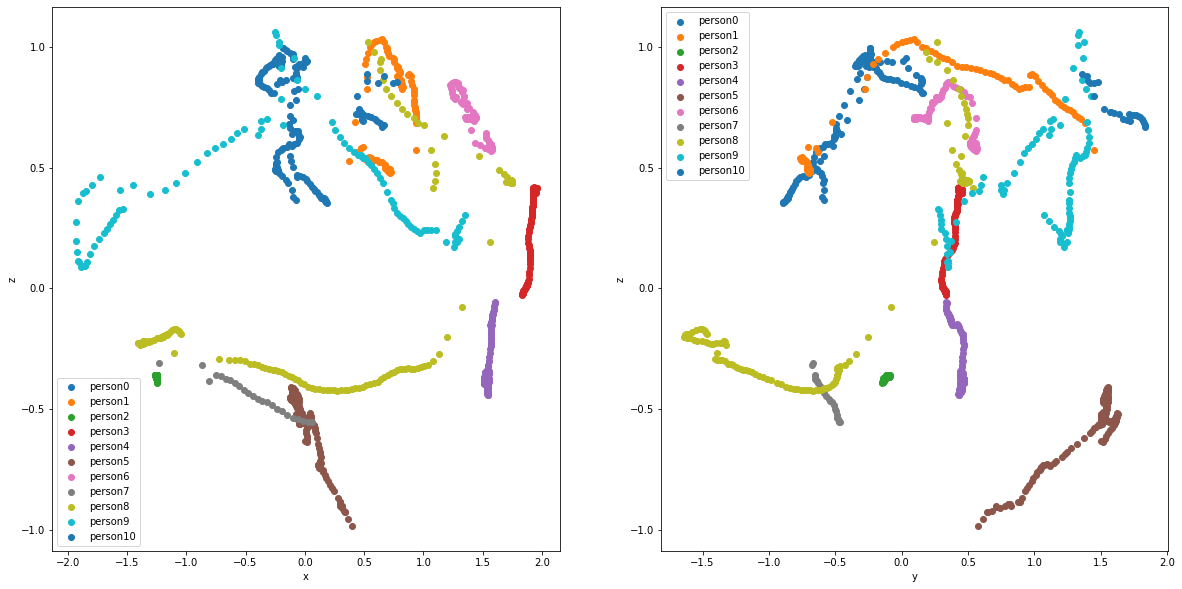

In [76]:
ROOM_NUM = '02'
DATE = '20210903'
FILE_NUM = '07'

fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
for key, features in features_dict.items():
    if key.split('_')[:2] != [ROOM_NUM, FILE_NUM]:
        continue
    if len(features) == 0:
        continue
    
    features = list(features.values())
    features = pca.transform(features)
    x = features.T[0]
    y = features.T[1]
    z = features.T[2]
    ax1.scatter(x, z, label=f"person{key.split('_')[-1]}")
    ax1.set_xlabel('x')
    ax1.set_ylabel('z')
    ax1.legend()
    ax2.scatter(y, z, label=f"person{key.split('_')[-1]}")
    ax2.set_xlabel('y')
    ax2.set_ylabel('z')
    ax2.legend()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 873/873 [00:02<00:00, 418.21it/s]


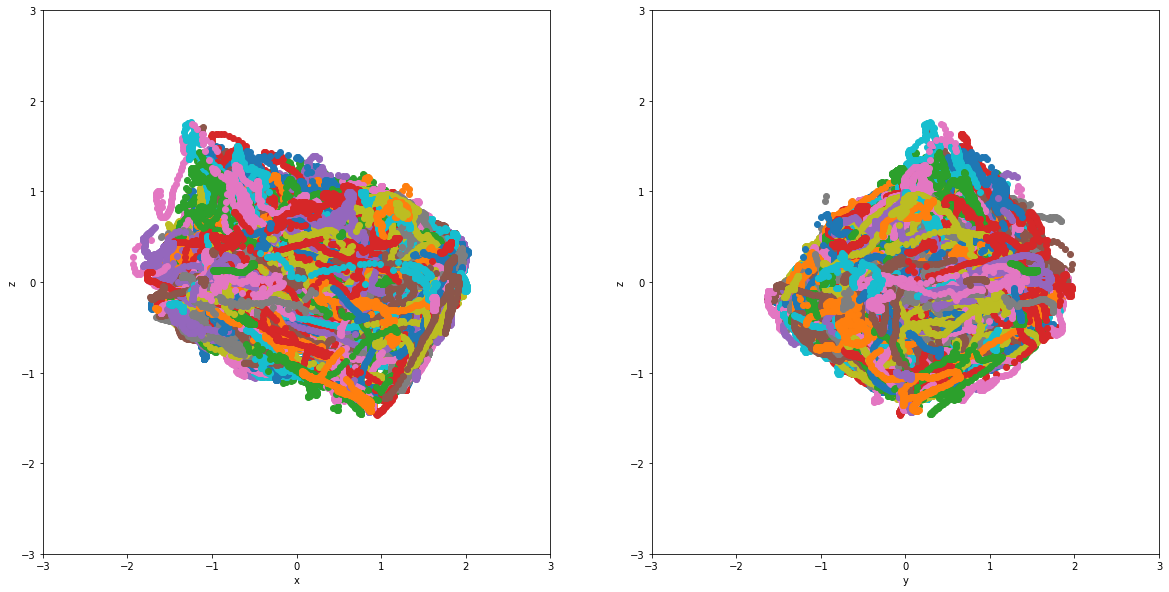

In [54]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
for key, features in tqdm(features_dict.items()):
    if len(features) == 0:
        continue
    
    features = list(features.values())
    features = pca.transform(features)
    x = features.T[0]
    y = features.T[1]
    z = features.T[2]
    
    ax1.scatter(x, z)
    ax1.set_xlabel('x')
    ax1.set_ylabel('z')
    ax1.set_xlim((-3, 3))
    ax1.set_ylim((-3, 3))
    ax2.scatter(y, z)
    ax2.set_xlabel('y')
    ax2.set_ylabel('z')
    ax2.set_xlim((-3, 3))
    ax2.set_ylim((-3, 3))
plt.show()

# k-means

In [64]:
data_array = pca.transform(features_all)

In [66]:
max_cluster_num = 10
sse = np.zeros((max_cluster_num,))     # Sum of Square Error（クラスタ内誤差平方和）
se = np.zeros((max_cluster_num,))      # Sum of Error（クラスタ内誤差和）
inertia = np.zeros((max_cluster_num,)) # scikit-learnにより自動計算するクラスタ内誤差平方和

for i in range(max_cluster_num):
    cluster_num = i + 1
    kmeans = KMeans(n_clusters=cluster_num)
    # 各データがどのクラスタに所属するか
    pred = kmeans.fit_predict(data_array)
    inertia[i] = kmeans.inertia_

    # 各データが自身の所属するクラスタ中心からどれだけ離れているか調べる
    transforms = kmeans.transform(data_array)    
    distances = np.zeros(len(data_array))
    for index in range(len(transforms)):
        distances[index] = transforms[index, pred[index]]

    se[i] = np.sum(distances)
    sse[i] = np.sum(distances**2)

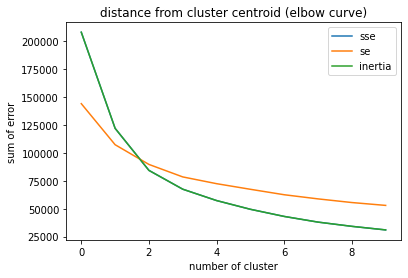

In [67]:
plt.title('distance from cluster centroid (elbow curve)')
plt.xlabel('number of cluster')
plt.ylabel('sum of error')
plt.plot(sse,label='sse')
plt.plot(se,label='se')
plt.plot(inertia,label='inertia')
plt.legend()
plt.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

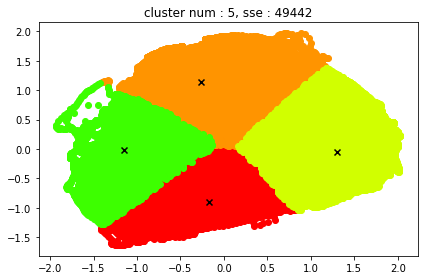

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

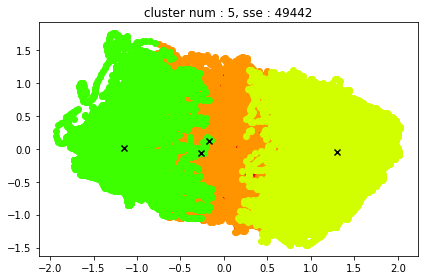

In [71]:
from matplotlib import cm
optical_cluster_num = 4

kmeans = KMeans(optical_cluster_num)
kmeans.fit(data_array)
pred = kmeans.predict(data_array)
centers = kmeans.cluster_centers_

for k in range(optical_cluster_num):
    target = data_array[pred==k]
    color = cm.hsv(float(k) / cluster_num)
    plt.scatter(target[:, 0], target[:, 1], c=color)
plt.scatter(centers[:, 0], centers[:, 1], marker='x', c='black')
plt.title('cluster num : {}, sse : {:.0f}'.format(current_cluster_num, inertia[current_cluster_num]))
plt.tight_layout()
plt.show()

for k in range(optical_cluster_num):
    target = data_array[pred==k]
    color = cm.hsv(float(k) / cluster_num)
    plt.scatter(target[:, 0], target[:, 2], c=color)
plt.scatter(centers[:, 0], centers[:, 2], marker='x', c='black')
plt.title('cluster num : {}, sse : {:.0f}'.format(current_cluster_num, inertia[current_cluster_num]))
plt.tight_layout()
plt.show()